# Quantifying Gerrymandering in North Carolina


### Collaborators

Aditya Karan, Manish Reddy Vuyyuru, Zizheng Xu

In [62]:
import mcmc_code, os, time
#GerryChain and it's dependencies are needed. Use GerryChain 0.2.4
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally, county_splits, boundary_nodes, cut_edges, cut_edges_by_part, exterior_boundaries, interior_boundaries, perimeter

from gerrychain import MarkovChain
#importlib.reload(gerrychain.MarkovChain)
#REQUIRES GERRYCHAIN 0.2.14

from gerrychain.constraints import single_flip_contiguous, districts_within_tolerance, no_vanishing_districts, contiguous
from gerrychain.constraints.validity import deviation_from_ideal
from gerrychain.proposals import propose_random_flip
import gerrychain.scores
from gerrychain import Election
from gerrychain.constraints.validity import deviation_from_ideal
from gerrychain.accept import always_accept
import random
import importlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
importlib.reload(mcmc_code)
from gerrychain.constraints import Validator


## Motivation and Objective

In politics, [Gerrymandering](https://en.wikipedia.org/wiki/Gerrymandering)  is the practice of intentionally manipulating voting districts in a given region to favor a given party. Often this results in relatively [outlandish shapes of voting districts](https://www.washingtonpost.com/news/wonk/wp/2014/05/15/americas-most-gerrymandered-congressional-districts/?noredirect=on&utm_term=.b80135dfefec). However, the practice remains widespread. In particular, the courts haven't addressed whether one could go to far in explict partisn gerrymandering. The question has often come down to measurabilty - in 2004, Justice Kennedy wrote in his opinion [VIETH V. JUBELIRER](https://www.law.cornell.edu/supct/html/02-1580.ZC.html), states that while the court declained to intervene in this particular map "	the failings of the many proposed standards for measuring the burden a gerrymander imposes on representational rights make our intervention improper.	If workable standards do emerge to measure these burdens, however, courts should be prepared to order relief."

Several measures of partisin gerrymandering have arisen since that time. However, quantifying how much a certian map is biased one way or another alone cannot demosntrate gerrymandering - because of our desire for compactness of districts, keeping relevant natural communites as in the same district and complince of the Voting Rights Act, just scoring a map can't address the problem. 

Luckily there is a solution that can help! If we were able to sample a set of reasonable maps, we can quantify over the possible sets of reasonable graphs - what are the expected numbers of wins etc across this ensamble. Hence Markov Chain Monte Carlo provides a opportunity for us to generate these samples of maps. Once we have a sample we can compute these various statisics and compare to the actual maps to come up with a way of telling whether a given map's statistics would come up by chance or is there a concerted effort to gerrymander. 

This tutorial is based on "Quantifying Gerrymandering in North Carolina" (https://arxiv.org/pdf/1801.03783.pdf)




## GerryChain

We will leverage the GerryChain python package to help organize our data and learn how to start sampling the set of all maps

To start - we've provided data shapefiles/geojson files to aide. These are a best effort means of reconcilling precient level election data and population data - needed to help sample.

The two main objects we'll be concerned about are "Graph" objects and "Partition" objects. Graph objects can be geenrate by the Geojson/Shapefiles and give us back a networkx like graph - where the nodes are analogus to precients and the edges represnt two precients being geographically adjacent. 

A partition is a split of the graph into $n$ number of parts. Here we want to partition into $13$ districts. 


In [2]:
filepath = os.path.join("old_new_NC")
graph = mcmc_code.generate_graph(filepath)
# Manual Bugfix - don't worry about it
graph.nodes[2293]['2014_CD'] = 2
graph.nodes[2349]['2014_CD']  = 4


C:\Users\Aditya\Anaconda3\envs\gdaltest2\lib\site-packages\gerrychain\graph\adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(298, 299), (2262, 2263), (2390, 2391), (2486, 2487), (676, 677), (1436, 1437), (2301, 2302), (2646, 2647), (2742, 2743), (1576, 1577), (1118, 1119), (302, 303), (722, 723), (990, 991), (994, 995), (1198, 1199), (1438, 1439), (2258, 2259), (2578, 2579), (544, 545), (300, 301), (1108, 1109), (2260, 2261), (2740, 2741), (1016, 1017), (2585, 2586), (2723, 2724), (165, 166), (293, 294), (644, 645), (1020, 1021), (1028, 1029), (2729, 2730), (681, 682), (1257, 1258), (1022, 1023), (1026, 1027), (1394, 1395), (683, 684), (2475, 2476), (640, 641), (657, 658), (1013, 1014), (1205, 1206), (2477, 2478), (835, 836), (1039, 1040), (2678, 2679), (1034, 1035), (1418, 1419), (2538, 2539), (1032, 1033), (1087, 1088), (838, 839), (2299, 2300), (2746, 2747), (1420, 1421), (1428, 1429), (2676, 2677), (1241, 1242), (2649, 2650), (2744, 2745

And for the partition - we'll split first by the default and plot to get a look

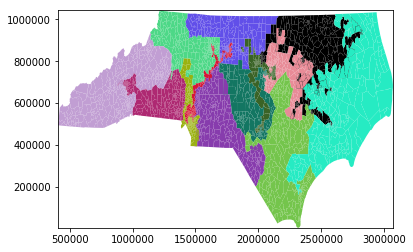

In [3]:
#This will let us keep track of elections in different partitions!

election = Election(
        "2014 Senate", 
        {"Democratic": "sen_blue", "Republican": "sen_red"},
        alias="2014_Senate"
    )


sample_partition = Partition(
            graph,
            assignment="2014_CD", #Actual congressional district partition from the initial dataset
            updaters={
                "2014_Senate": election,
            }

)
mcmc_code.plot_state(sample_partition) 

We can already see these shapes are a bit funky, but how funky are the actual outcomes?

Now to run a simple GerryChain example - we can set up a Markov Chain. We'll use GerryChain's implementation of a Markov Chain to avoid redoing work! As with a typical markov chain, we need an initial state for the chain, a method for proposing the next step in the chain, optionally constraints to determine if a proposed state if valid and an acceptance probability for the proposed state (keyword argument: accept). And of course, the number of steps to run the chain for. Here, in particular, our step in our markov chain is labelled as "propose_random_flip". Essentially, we look at the edges in which the nodes are part of two different districts. Out of all those edges, we pick one and then with $\frac{1}{2}$ flip the node to the other district.



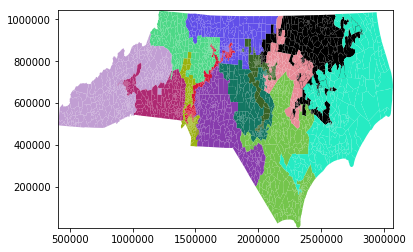

In [4]:
num_samples = 100
chain = MarkovChain(
        proposal=propose_random_flip,# Does the node flip based on conflicted edges as describe above 
        is_valid=single_flip_contiguous, # A function that alwaysd returns true
        accept=always_accept, # A function that also always returns true
        initial_state=sample_partition, # Start with partition above 
        total_steps= num_samples,
)

simple_part = []
wins = []
for partition in chain:
    # The below is to check whether a given partition has been accepted
    # In this case it's always accepted so always true
    if(hasattr(partition, 'accepted') and partition.accepted):
        wins.append(partition["2014_Senate"].wins("Democratic"))
        simple_part.append(partition)

mcmc_code.plot_state(simple_part[-1]) 

Congrats - you just run your first chain!!

But something seems odd. Are there any constraints? Aren't there some districts that we would prefer to others? Do we really want to choose all districts? 

Good observation! Some districts are "better" than others in some sense, and we want to take that in consideration. 

In MCMC language, we consider all possible maps to be sampled from some probablity distribution. We would like to consider the probablity distribution of "reasonable maps" as the probablity distribution we're pulling from. 

To do this  - we'll implement a Metropolis-Hasting criteria and build up our sampling function based on our idea of a "good" map

`

# Score Functions

To begin, we will be rigorous (we're forced to!) in defining what we consider to be a "good" map by assigning a probability for each map to be considered "good". We will rely on design criteria set forward by state laws in arriving at this probability. In particular for North Carolina, the House Bill 92 (HB92) of the NC General Assembly requires the following:

* 1. the state population is evenly divided between the thirteen congressional districts,
* 2. the districts are connected and compact,
* 3. splitting counties is minimized, and
* 4. African-American voters are sufficiently concentrated in two districts to affect the winner.

Thus, the task can be broken down into how well we think that a given map adheres to each of the 4 criteria above. Let's consider each of these one by one. 

### Population Score


Ideally, we want the total population to be split evenly among all the 13 districts. Of course, it would be impossible that each distract have _exactly_ this population. We will thus define a measure of how much we 'dislike' a map for having districts that deviate from this ideal. For this, we will employ the typical [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) to quantify the deviation. Lets look at the distribution of populations and how well it adheres to the criteria for the map we just saw!

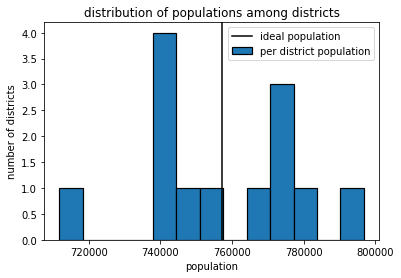

MSE score for district populations: 0.10552739432589746.


In [5]:
#we need to refine the partition to now track the population which we will need to calculate this score!
sample_partition = Partition(
            graph,
            assignment="2014_CD", #Actual congressional district partition from the initial dataset
            updaters={
                "population": Tally("population", alias="population") #Track population per district to determine adherence to criteria 1
            }

)

#handy function from gerrychain that returns deviations per state from ideal
deviations = deviation_from_ideal(sample_partition, 'population')

#visualize the population distribution
population_per_district = list(sample_partition['population'].values())
plt.hist(population_per_district, edgecolor='black', linewidth=1.2, bins=13, label='per district population')
plt.axvline(np.mean(population_per_district), color='k', label='ideal population')
plt.xlabel('population')
plt.ylabel('number of districts')
plt.title('distribution of populations among districts')
plt.legend()
plt.show()

#mean squared error of the deviations
score = np.linalg.norm(list(deviations.values()))
print('MSE score for district populations: {}.'.format(score))

#mcmc_code.plot_state(sample_partition) 

Notice here that distribution of the actual population per district is all over the place, with a district with population almost 40000 above the ideal and a district with a population almost 40000 below! Correpsondingly, this particular districting plan receives a MSE score for its population distribution well above 0! A score of 0 would correspond to a perfectly even distribution of populations between the districts. 

### Compactness Score

Besides having an even distribution of population between districts, we want a 'good' map to also have districts that are connected and compact. For example, consider the red district in the map above! Does it not seem very odd? It seems to be stretched so thin! This appearance is characterised well by the ratio of the districts perimeter to its area. We will quantify how 'compact' a map is by measuring the total of the ratios of the square of the perimeter and the area of each district (the _isoperimetric score_). The ideal shape of a district would be the most compact share, a circle! In the paper, the authors argue that a score of under 60 is 'almost always reasonably compact'. Lets again use the map above to measure how compact the districts are.

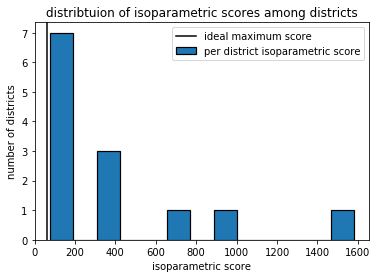

sum of the ratio of squared perimeter to area per district: 5324.708856284146.


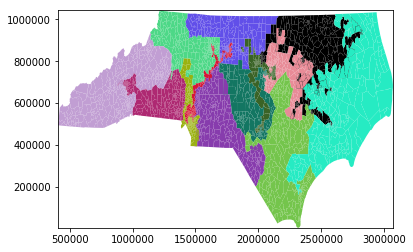

In [6]:
# #again, we need to redefine the partition to now track the area and perimeter. 
# For the other scores we'll keep track of the other quantities below as well

election = Election(
        "2014 Senate", 
        {"Democratic": "sen_blue", "Republican": "sen_red"},
        alias="2014_Senate"
    )

sample_partition = Partition(
            graph,
            assignment="2014_CD", #Actual congressional district partition from the initial dataset
            updaters={
                "2014_Senate": election,
                "population": Tally("population", alias="population"), 
                "exterior_boundaries": exterior_boundaries,
                "interior_boundaries": interior_boundaries,
                "boundary_nodes": boundary_nodes,
                "cut_edges_by_part": cut_edges_by_part, 
                "perimeter": perimeter,
                "area": Tally("area", alias="area"),
                 "county_split" : county_splits( 'county_split', "COUNTY_ID"),
                "black_population": Tally("black_pop", alias = "black_population"),


            }

)

#looping over all the districts and calculation the sum of the perimeter squared, area ratio~
isoparametric_parts = []
for part in sample_partition.parts:
    area, perimeter = sample_partition['area'][part], sample_partition['perimeter'][part]
    isoparametric_parts.append(perimeter**2/area)
    
#visualize the distribution of isoparametric scores
plt.hist(isoparametric_parts, edgecolor='black', linewidth=1.2, bins=13, label='per district isoparametric score')
plt.axvline(60, color='k', label='ideal maximum score')
plt.xlabel('isoparametric score')
plt.ylabel('number of districts')
plt.title('distribtuion of isoparametric scores among districts')
plt.legend()
plt.show()

#sum of isoparametric scores
score = np.sum(np.array(isoparametric_parts))
print('sum of the ratio of squared perimeter to area per district: {}.'.format(score))

mcmc_code.plot_state(sample_partition) 

Some of the districts in the map have a hilariously large compactness score compared to what was considered reasonably (~<60)! There's a district with a score of >1400! This is as we had suspected (e.g. just look at how needle-like the red district is).

### County-Split Score

Similarly, we can also define scores to quantify the other criteria. Namely, we still have the degree to which counties are split between districts in a given map, which we can score simplify by counting the split counties! 

We simply have to look at the counties which lie in more than one district - and assign a score that penalize the amount in which they cross over. We also want to penalize counties that are split more than 3 ways or more than just a 2 county split. 

More concerately, we define the score as 

$J_c(\xi) = N_2 \cdot W_2(\xi) + N_3 \cdot W_3(\xi) \cdot M_C$

Where $N_2$ is the number of counties split between $2$ district,s $N_3$ is the number split between $3$ or more, and $M_C$ is some large constant to strongly penalize splitting counties into more than $2$ districts. 
$W_2(\xi) = \sum_{\text{counties in 2}} (\text{Fraction VTD in 2nd largest})^{\frac{1}{2}}
 $
 
 $W_3(\xi) = \sum_{\text{counties in 3 or more}} (\text{Fraction VTD in not in top 2 largest})^{\frac{1}{2}}
 $
Because there are some counties that have more people than a congressional district can hold - this score will never be 0

The implementation is below. 




In [7]:
def county_split_wrapper(partition, county_split_name = 'county_split', district_name = 'county_split'):
    '''Wrapper to compute the score'''
    splits = county_split_score(partition, county_split_name)
    score = compute_countySplitWeight(partition, splits, county_split_name, district_name)
    return(score)
    
def county_split_score(partition, county_split_name = 'county_split'):
    splits = partition[county_split_name]
    to_check = {}
    for s in splits:
        num_split = len(splits[s][2])
        if(num_split > 1):
            prev = to_check.get(num_split, [])
            prev.append(s)
            to_check[num_split] = prev
    return(to_check)

def compute_countySplitWeight(partition, info, county_split_name = 'county_split', district_name = "county_split"):
    '''Compute the county score function as described by the paper
    Takes in a parition with a county score_split data and computes the final 
    score'''
    two_counties = info[2]
    two_county_weight_sum = 0
    '''FIxme - should really combine both parts'''
    for c in two_counties:        
        nodes = partition[county_split_name][c][1]
        counties = [partition.assignment[n] for n in nodes]
        cn = Counter(counties)
        second_frac = cn.most_common(2)[1][1]/ sum(cn.values())
        two_county_weight_sum += np.sqrt(second_frac)
    
    three_plus_weight_sum = 0
    to_consider = list(info.keys())
    to_consider.remove(2)
    for count_counties in to_consider:
        counties_split_list = info[count_counties]
        for c in counties_split_list:
            nodes = partition[county_split_name][c][1]
            counties = [partition.assignment[n] for n in nodes]
            cn = Counter(counties)
            temp_frac = 0
            lst = cn.most_common()
            for i in range(2, len(lst)):
                temp_frac += lst[i][1]
            temp_frac = temp_frac / sum(cn.values())
            three_plus_weight_sum += np.sqrt(temp_frac)
    
    # Comput the 2 county split weight vs the 3 
    num_2 = len(two_counties)
    flat_list = [item for sublist in list(info.values()) for item in sublist]
    num_3plus = len(flat_list) - num_2
    # Says to use large number for three_plus_weight...
    final_score = two_county_weight_sum * num_2 + num_3plus * three_plus_weight_sum * 100
    if(final_score < 0):
        raise Exception("FInal weight should be less than 0")
    return(final_score)



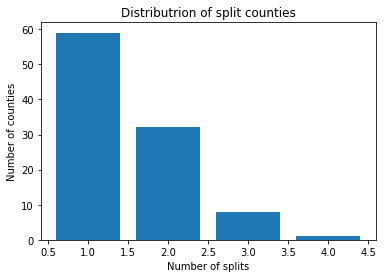

In [8]:
#again, we need to redefine the partition to now track the area and perimeter
num_counties = county_split_score(sample_partition)
total_c = sample_partition['county_split']
c_to_split = []
num_to_plot = []
for key, val in num_counties.items():
#    print(key)
    num_to_plot.append(len(val))
    c_to_split.append(key)
c_to_split.append(1)
num_to_plot.append(len(total_c) - sum(num_to_plot) )
plt.bar(c_to_split, num_to_plot )
plt.xlabel("Number of splits")
plt.ylabel("Number of counties")
plt.title("Distributrion of split counties")
plt.show()
#print(num_counties)


### Minority Score

Finally - we have to consider the Voting Rights Act - which legistates that within states that have a significant enough minorities must construct some districts in a way such that the minorities have the ability to choose their representatives. 

In practice, this means that there has to be some set of districts with large number of minority population so that that block of people can control an election result. 

In North Carolia - this primarily concerns Black Voters. Based on the population size, the VRA would argue that there needs to be at least 2 districts in which black voters have a large prescene. 

The last time NC went to court, it deemed the percentage splits of 44.5% and 36.9% to be sufficient to not be blocked under the VRA. Hence for our model, if the top 2 districts by black percents satities those percents - we assign $0$ score, otherwise we penalize for not satisifying the VRA. 

Formally we write this as 
$J_m(\xi) = \sqrt{H(0.4448 - m_1)} + \sqrt{H(0.3620 - m_2)}$ where $m_1$ and $m_2$ are the first and second largest districts by fraction of black population, and $H(x) = 0$ for $x \leq 0$ and $H(x) = x$ for $x > 0$

In [9]:
def vra_district_requirement(partition, num_districts = 2, thresholds = [0.445, 0.36]):
    if(len(thresholds) != num_districts):
        raise Exception("Number of thresholds needs to equal the number of districts you want")
    black_pop_dict = partition['black_population']
    total_dict = partition['population']
    fractions = Counter({k : black_pop_dict[k] / total_dict[k] for k in total_dict})
    top_n = fractions.most_common(num_districts)
    thresholds.sort(reverse = True)
    score = 0
    for i in range(0, num_districts):
        #Get the max thresholds
        temp_score = max(0, thresholds[i] - top_n[i][1])
        score += np.sqrt(temp_score)
    return(score)


    

In [10]:
print("VRA score is %f" % vra_district_requirement(sample_partition))

VRA score is 0.000000


### Relative Importance of Scores (Weighting)


We can now put all these pieces together to define our score function as a linear combination of the above, namely $J(\xi) = w_p J_p(\xi) + w_I J(\xi) + w_c J_c(\xi) + w_m J_M(\xi)$

where: 

1. the population score $J _ { p } ( \xi )$ : measures how well the redistricting ξ partitions the population of North Carolina into 13 equal population
groups; 

2. the isoperimetric score  $J _ { I } ( \xi ) $: measures how compact the districts are; 

3. the county score $J _ { c } ( \xi )$: measures the number of counties split between multiple districts; 

4. the minority score  $J _ { m } ( \xi )$ measures the extent to which a districting plan adheres to the VRA

and:

$w _ { p } , w _ { I } , w _ { c } ,$ and $w _ { m }$ are a collection of positive weights to be determined.

These weights help to tune and balance the relative importance of these 4 criteria in defining what we consider to be a 'good' map. The weights were determined by the following iterative process, and with $\beta$ set to 1 throughout (so the score actually has an effect during the simulated annealing process -- see below for details!!):

1. Starting with all the weights set to 0, find the smallest $w_{p}$ such that about a quarter of the sample redistrictings have a reasonable population deviation (paper using 0.5% for NC).

2. Now attempt to find the smallest $w_{I}$ while keeping some fraction of districts below some ideal isoparametric ratio (paper uses ~10% of districts below the previously discussed reasonable score of 60). If condition for $w_{p}$ in step1 is violated, repeat steps 1-2.

3. Now attempt to find the smallest $w_{m}$  such that at least 50% of all redistricting plans sampled have a reasonable number of African Americans in the top 2 districts to meet VRA (paper uses African American percentage splits of at least 40% and 33.5% in the top 2 districts for NC) . Again, if the conditions for $w_{I}$ were violated, repeat steps 2-3 or if conditions for $w_{p}$ were violated, repeat steps 1-3.

4. Finally, attempt to find the smallest $w_{c}$ such that county splits are nearly always limited to two county splits and that there are on average a relatively small number of two county splits (paper uses average of less than 25 two county splits for NC).

But for North Carolina, we'll go ahead and use the paper's value of  $w_p = 3000, w_I = 2.5, w_c = 0.4, w_m = 800.$

In addition to these parameters, we also have the low and high temperatures
corresponding respectively to the maximum and minimum β values used in simulated annealing. We have set the minimum value of β to
be zero which corresponds to infinite temperature. In this regime, no district is favored over any other, which allows the redistricting plan
freedom to explore the space of possible redistrictings.


In [11]:
def score_partition(partition, wp, wi, wc, wm):
    return(mcmc_code.equal_split_score(partition) * wp + mcmc_code.compactness_split_score(partition) * wi + 
           county_split_wrapper(partition) * wc + vra_district_requirement(partition) * wm)

def metro_scoring_prob(partition, beta, wp, wi, wc, wm):
    if(partition.parent == None):
        return True
    conflictedp = len(partition['cut_edges'])
    conflicted = conflictedp
    conflicted = len(partition.parent['cut_edges'])
    ratio = conflicted/conflictedp
    curr_score = score_partition(partition, wp, wi, wc, wm)
    prev_score = score_partition(partition.parent, wp, wi, wc, wm)
    exp = np.exp(-beta * (curr_score - prev_score))
    prob = min(1, ratio * exp)
    return(prob > random.random())
    


### Problem Representation

Before we start to talk about the sampling and look at some results, let's start to get into the nitty-gritty of it. To put things on more formal footing, note that we have not yet cast the problem tractable fashion. What exactly is a district? And how do we propose a systematic method to move district boundaries across? To do this, we will define a graph that represents the state, in this case North Carolina.

The graph will consist of vertices which each represent a Voting Tabulation District (VTD). Edges exist between two vertices that share a geographical boundary. A redistricting plan can then be formally defined as a function that maps every one of the vertices (that each represent at VTD) to sequential integers from 1-13 that each represent one of the thirteen congressional districts of North Carolina.

Formally, let $V$ be the vertices, $E$ the edges, we're saying that we have a function:
$$ \xi : V \rightarrow 1,2, ..., 13$$
that is mapping each vertex to a district ID.

### Sampling Scheme

Our sampling scheme can thus be summarised as follows:

* 1. Randomly choose a vertex that lies at the boundary between districts. I.E. randomly choose an edge $E$ between vertices $U$ and $V$ where $U$ and $V$ satisfy $\xi(U) \neq \xi(V)$.

* 2. With a probability of $\frac{1}{2}$, flip the district of one of the two vertices connected by the chosen edge. I.E. with probability $\frac{1}{2}$ either:

$$\xi^{'} = \left\{
                \begin{array}{ll}
                  \xi(w) \>\>\>w \neq u\\
                  \xi(v) \>\>\>\>u
                \end{array}
              \right. $$
              
$$or$$ 

$$\xi^{'} = \left\{
                \begin{array}{ll}
                  \xi(w) \>\>\>w \neq v\\
                  \xi(u) \>\>\>\>v
                \end{array}
              \right. $$
              
We will herein refer to this edge $E$ between vertices $U$ and $V$ as a _conflicted_ edge. Let $conflicted(\xi)$ represent the number of conflicted edges given the districting plan $\xi$ and $J(\xi)$ be the scoring function for how 'good' a district is as discussed above. We arrive at an acceptance probability for our Metropolis-Hasting criteria of:

$$ p = \min(1, \frac{conflicted(\xi)}{conflicted(\xi^{'})}e^{-\beta(J(\xi^{'}) - J(\xi))})$$

### Simulated Annealing

Notice here a particular problem with the strategy that we've proposed. On a high level, we are interested in exploring the redistricting plans in the space of _all possible_ plans. However, we have proposed to do this by starting from a particular redistricting plan to iterate from. This initial districting plan for North Carolina (which you might or might not suspect is not representative of a "normal" district) would thus influence the trajectory of the chain very heavily. To get around this, we will use simulated annealing to sample the space of redistricting plans. Notice that we have already written this (see the $\beta$ parameter, representing inverse temperature) in the acceptance probability that we have defined above! By starting our markov chain (steps 0 - 40000) with $\beta$ set to 0, we will sample the space in a regime where no district is favored over any other, thus allowing us to access the large space of possible districtings without being tied down by our choice of initial districting plan. The inverse temperature $\beta$ is then slowly increased in subsequent steps (steps 40000 - 60000) to allow the sampling of districting maps that seem 'good' (low score) without getting trapped in local optimas. Finally, $\beta$  is fixed to 1 for a number of steps to locally sample the 'best' districting maps (steps 60000-80000).

This is all great! But unfortunately, the Gerrychain MarkovChain class doesn't allow for annealing - so we have created a new class MarkovChainAnnealing - to allow for the simulating annealing (the change is pretty small and can be viewed in the supporting files for more information).

### Constraints

In addition to these scoring, we also require in our MCMC to strictly match certian properties - if it doesn't, it is immediatley rejected. This is meant to exclude maps that, while may have a score, would not satisfy the law in a reaosnable manner. 

Our three constraints we impose in this situation are: 


*   The difference between the max popuation district and min population district is no more than 0.12%
*  The districts are contigious - if a node is assigned a district, there it has at least one neighbor that's also in the same district
*   There is some VRA condition satisfied. For this purpose, we reject all maps where the top 2 black population fraction are below 40% and 33.5%. 

This can also be thought of as setting the score function to $\infty$. We take these steps in order to limit the generated partitions to be ones that could be enacted


Now with all that out of the way, lets sample!


In [12]:
def run_simple(graph, initial_partition, num_samples = 80000, wp = 3000, wi = 2.5, wc = 0.4, wm = 800, get_parts = 5):
    # We care about the senate election across the districts
    election = Election(
        "2014 Senate",
        {"Democratic": "sen_blue", "Republican": "sen_red"},
        alias="2014_Senate"
    )    
    '''Validations, the VRA validator, districts in toelrance and single_flip contigious '''
    def vra_validator(part):
        if(vra_district_requirement(part, 2, [0.4, 0.335]) > 0):
            return False
        return True

    districts_within_tolerance_2 = lambda part : districts_within_tolerance(part, 'population', 0.12)
    #Combination of validators
    is_valid = Validator([single_flip_contiguous, districts_within_tolerance_2, vra_validator ])
    
    '''Acceptance function - does simulated annealing and scores'''
    def accept(partition, counter):
        if(counter < 40000):
            beta = 0
        elif(counter < 60000):
            beta = (counter - 40000) /(60000-40000)
        else:
            beta = 1
        return(metro_scoring_prob(partition, beta, wp, wi, wc, wm))

    # See the mcmc_code.py for the definition 
    chain = mcmc_code.MarkovChainAnneal(
        proposal=propose_random_flip, #Choose node from cut edge
        is_valid=is_valid, # Validate strict
        accept=accept, #Acceptance probablity 
        initial_state=initial_partition, # num_prations
        total_steps= num_samples * 100, # silly gerrychain convention - so overload and count ourselves
    )
    # going to show 5 partitions from this sample
    part_con = max(1, num_samples / get_parts) # picking evenally spaced partitions to plot
    
    efficiency_gaps = []
    wins = []
    voting_percents = []
    sample_parts = []
    tbefore = time.time()
    for partition in chain:
        if(hasattr(partition, 'accepted') and partition.accepted):
            '''Compute the effiecny gaps, #wins and voting percents by party for each election'''
            efficiency_gaps.append(gerrychain.scores.efficiency_gap(partition["2014_Senate"]))
            wins.append(partition["2014_Senate"].wins("Democratic"))
            voting_percents.append(partition["2014_Senate"].percents("Democratic"))
            num_s = len(wins)
            if(num_s % part_con) == 0:
                sample_parts.append(partition)
            if(num_s> num_samples):
                break
            if(num_s % 1000 == 0):
                tnext = time.time()
                print("It took %i time to get 1000 samples" % (tnext - tbefore))
                tbefore = time.time()
    return(efficiency_gaps, wins, voting_percents, sample_parts)


In [13]:
num_samples = 80000 # Change to 80k once done testing
(efficiency_gap, wins, win_percents, part ) = run_simple(graph, sample_partition, num_samples = num_samples)



It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 3 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 4 time to get 1000 samples
It took 6 time to get 1000 samples
It took 4 time to get 1000 samples
It took 6 time to get 1000 samples
It took 5 time to get 1000 samples
It took 5 time to get 1000 samples
It took 5 time to get 1000 samples
It took 6 time to get 1000 samples
It took 5 time to get 1000 samples
It took 6 time to get 1000 samples
It took 5 time to get 1000 samples
It took 6 time to get 1000 samples
It took 5 time to ge

### Samples! Now What?


Phew that took a while...but now we have all our samples. 


Let's take a look!



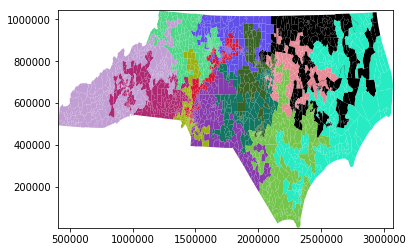

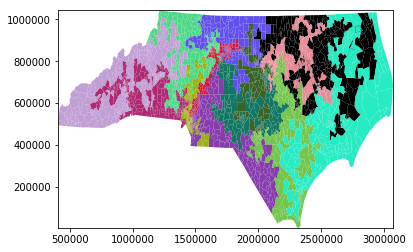

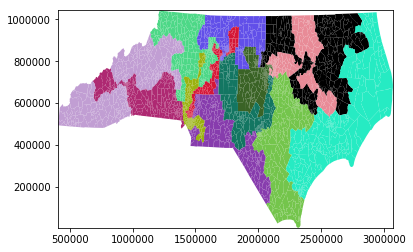

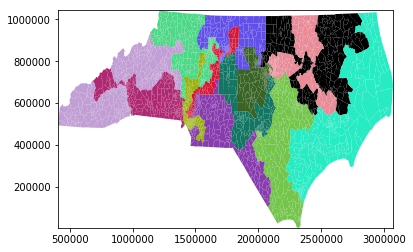

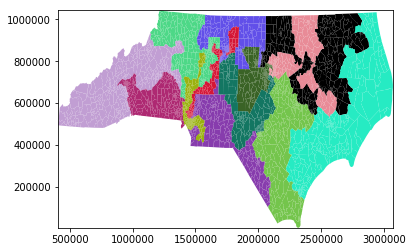

In [14]:
for p in part:
    mcmc_code.plot_state(p) 

One thing we will do off the bat is to "burn" the first 10-20k of our samples. Since we've picked a very specific starting partition - we want to read only really look at the egrodotic part of the distribution - hence the burn factor. 

Lets burn and see our results!

In [15]:
burn = 10000

### Metric Evaluation

Now, we will define several metrics that we can look at to see "how" gerrymandered a particular map is. 

The _efficency gap_ computes the net wasted vote for a party / total number of votes where a wasted vote is either the total number of votes for a party in a election they lost or the number of extra votes above what was reequired to win an election. The efficency gap is actually computed as part of the GerryChain, and the sampling code so we just use the output directly.

In the _representation index_ - we line up the percent of votes in a given district for a given party from most to least and label it. Examle $Y = [ 70, 60, 40 ]$, $X = [1, 2, 3]$ We then fit a line between the point above 50 and the point below 50 to see at which x would the party have won 50 (in this case the answer would be 2.5). This gives a continous way of looking at the number of election wons. 

In the _gerrymandering index_, for each sample, we order the elections by percent votes. From this we can take an average component wise (take the average result of the top election by percent vote, second most etc..) 
The gerrymandering index for a sample is the root mean square difference between the average and a give sample. 



In [16]:
def rep_index(win_percents):
    a = np.array(win_percents)
    a.sort()
    least_rep = 1 - a[np.argmax(a > 0.5)]
    least_dem = a[np.argmin(a < 0.5) + 1]
    num_win = len(a) - np.argmax(a > 0.5)
    delta = (50 - (100 - least_dem ))/(least_rep - (100 - least_dem))
    score = num_win + delta
    return(score)

def gerrymandering_index(average_sample, each_sample):
    a = np.array(average_sample)
    b = np.array(each_sample)
    a.sort()
    b.sort()
    return(np.linalg.norm(a - b))

def avg_sample(win_percents_arr):
    order = {}
    for i in range(1, 1 + len(win_percents_arr[0])):
        order[i] = 0
    for j in range(len(win_percents_arr)):
        elem = list(win_percents_arr[j])
        elem.sort()
        for s in range(len(elem)):
            order[s + 1] += elem[s]
    for i in range(1, 1 + len(win_percents_arr[0])):
        order[i] *= 1/len(win_percents_arr)
    fin = list(order.values())
    fin.sort(reverse = True)
    return(fin)



In [17]:
gerry_val = []
rep_val = []
avg = avg_sample(win_percents[:burn])
for elem in win_percents:
    rep_val.append(rep_index(elem))
    gerry_val.append(gerrymandering_index(avg, elem))

In [18]:
'''Get our initial statistics also'''
init_percents = sample_partition["2014_Senate"].percents("Democratic")
init_wins = sample_partition["2014_Senate"].wins("Democratic")
init_efficiency =(gerrychain.scores.efficiency_gap(sample_partition["2014_Senate"]))
init_rep_val = rep_index(init_percents)
init_gerry_val = gerrymandering_index(avg, init_percents)

C:\Users\Aditya\Anaconda3\envs\gdaltest2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


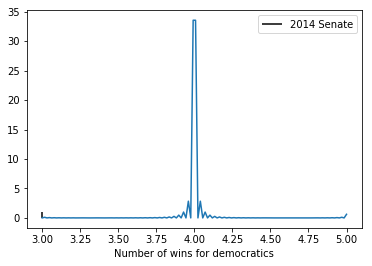

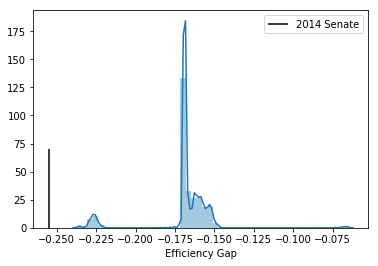

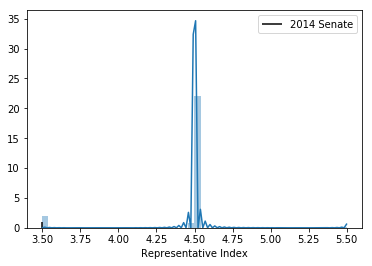

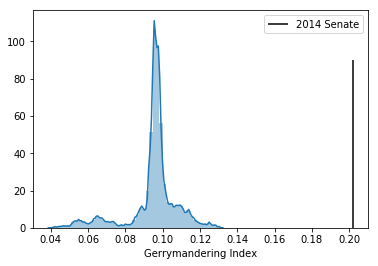

In [19]:
sns.kdeplot(wins[burn:])
plt.vlines(init_wins, 0, 1, label = '2014 Senate')
plt.xlabel('Number of wins for democratics')
plt.legend()
plt.show()

sns.distplot(efficiency_gap[burn:])
plt.vlines(init_efficiency, 0, 70, label = '2014 Senate')
plt.xlabel('Efficiency Gap')
plt.legend()
plt.show()

sns.distplot(rep_val[burn:])
plt.vlines(init_rep_val,0, 1, label = '2014 Senate')
plt.xlabel('Representative Index')
plt.legend()
plt.show()

sns.distplot(gerry_val[burn:])
plt.vlines(init_gerry_val, 0, 90, label = '2014 Senate')
plt.xlabel('Gerrymandering Index')
plt.legend()
plt.show()

We expect to see that in this sampling, the 2014 map prodcues measures such as efficiency gap, representtive index and gerrymandering value extremely skewed towards away. If it's extremely skewed - we believe therefore, that it is highly unlikely that this map was "pulled" randomly from the distribution on all reasonable maps. This suggests that there is some explicit partisian factor in creating this gap.

We can look at the credible 99% intervals and see if our values live somewhere in this range

In [20]:
lb = 0.5
ub = 99.5
interval = ub - lb
print("99 credible interval #wins is (%f, %f)" % (np.percentile(wins[burn:], 0.5), np.percentile(wins[burn:], 99.5)))
print("2014 Senate Wins is %f" % init_wins)
print("99 credible interval #eff_gap is (%f, %f)" % (np.percentile(efficiency_gap[burn:], 0.5), np.percentile(efficiency_gap[burn:], 99.5)))
print("2014 Senate eff gap is %f" % init_efficiency)
print("99 credible interval #rep_val is (%f, %f)" % (np.percentile(rep_val[burn:], 0.5), np.percentile(rep_val[burn:], 99.5)))
print("2014 Senate rep val is %f" % init_rep_val)
print("99 credible interval #gerry_val is (%f, %f)" % (np.percentile(gerry_val[burn:], 0.5), np.percentile(gerry_val[burn:], 99.5)))
print("2014 Senate gerry valis %f" % init_gerry_val)





99 credible interval #wins is (3.000000, 5.000000)
2014 Senate Wins is 3.000000
99 credible interval #eff_gap is (-0.232383, -0.070195)
2014 Senate eff gap is -0.255192
99 credible interval #rep_val is (3.499034, 5.499852)
2014 Senate rep val is 3.498026
99 credible interval #gerry_val is (0.047784, 0.126230)
2014 Senate gerry valis 0.201841


Based on these statistics it seems quite unlikely that the 2014 map was pulled singularly at random...3/4 statistics lie outside the 99% confidence interval. Based on this we may want to reach a conclusion that the 2014 map had ulterior motivations outside of the criteria set by redistricting guidelines

## Appendix

GerryChain 0.2.4 https://gerrychain.readthedocs.io/en/latest/

Data Source: We took the 2014 election data shapefile from http://mike.teczno.com/notes/redistricting/building-north-carolina-data.html

We then fixed up the shapefile geometries with Shapefiles provided by the North Carolina State board for 2014 Precients https://dl.ncsbe.gov/

We tried to also layer on 2016 precient data for comparision using the same precient files/ 2016 Congressional maps - but the resulting distribution of the population was not reasonable. Hence the 2016_NC column should be ignored. 

